In [4]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

import os, sys

# Relative paths
dirname = os.path.dirname
sep = os.sep

ml_folder = dirname(os.getcwd())
sys.path.append(ml_folder)

from src.utils import mining_data_tb as md
from src.utils import visualization_tb as vi

import warnings

warnings.filterwarnings("ignore")

In [5]:
# dfs
demographics_dfs = md.read_data(2, "1_demographics")
dietary_dfs = md.read_data(2, "2_dietary")
examination_dfs = md.read_data(2, "3_examination")
laboratory_dfs = md.read_data(2, "4_laboratory")
questionnaire_dfs = md.read_data(2, "5_questionnaire")

# variable names
variable_names = pd.read_csv("../data/6_variables/0_final_variables.csv", index_col = 0)

In [6]:
dem_var = ["RIAGENDR", "RIDAGEYR"]
diet_var = ["DR1TCHOL", "DR1TTFAT", "DR1TSFAT", "DR1TSUGR", "DR2TCHOL", "DR2TTFAT", "DR2TSFAT", "DR2TSUGR"]
#diet_var_2 = ["DR2TCHOL", "DR2TTFAT", "DR2TSFAT", "DR2TSUGR"]
exam_var = ["BPXDI1", "BPXSY1", "BMXWT", "DXDTOPF", "BMXWAIST"]
#exam_var_2 = ["BMXWT"]
#exam_var_3 = ["DXDTOPF"]
lab_var = ["LBXTR", "LBXTC", "LBXSGL"]
#lab_var_2 = ["LBXTC"]
quest_var = ["MCQ010", "MCQ160B", "MCQ160C", "MCQ160D", "MCQ160E", "MCQ160F"]
full_var = dem_var + diet_var + exam_var + lab_var + quest_var


##### DEMOGRAPHICS DATA
demo_h = demographics_dfs["demo_h"]
demo_i = demographics_dfs["demo_i"]
demo_j = demographics_dfs["demo_j"]

demo_data = pd.concat([demo_h, demo_i, demo_j])
#demo = demo.loc[:, dem_var]


##### DIETARY DATA
dr1tot_i = dietary_dfs["dr1tot_i"]
dr1tot_j = dietary_dfs["dr1tot_j"]
dr1tot_h = dietary_dfs["dr1tot_h"]

dr2tot_i = dietary_dfs["dr2tot_i"]
dr2tot_j = dietary_dfs["dr2tot_j"]
dr2tot_h = dietary_dfs["dr2tot_h"]

dr1tot = pd.concat([dr1tot_h, dr1tot_i, dr1tot_j])
dr2tot = pd.concat([dr2tot_h, dr2tot_i, dr2tot_j])
dietary_data = pd.merge(dr1tot, dr2tot, how = "outer", on = "SEQN")
#dietary_data = dietary_data.loc[:, diet_var]


##### EXAMINATION DATA
bpx_h = examination_dfs["bpx_h"]
bpx_i = examination_dfs["bpx_i"]
bpx_j = examination_dfs["bpx_j"]

bmx_h = examination_dfs["bmx_h"]
bmx_i = examination_dfs["bmx_i"]
bmx_j = examination_dfs["bmx_j"]

dxx_h = examination_dfs["dxx_h"]
dxx_i = examination_dfs["dxx_i"]
dxx_j = examination_dfs["dxx_j"]

bpx = pd.concat([bpx_h, bpx_i, bpx_j])
bmx = pd.concat([bmx_h, bmx_i, bmx_j])
dxx = pd.concat([dxx_h, dxx_i, dxx_j])

examination_data = pd.merge(bpx, bmx, how = "outer", on = "SEQN")
examination_data = pd.merge(examination_data, dxx, how = "outer", on = "SEQN")
#examination_data = examination_data.loc[:, exam_var]


##### LABORATORY DATA
trigly_h = laboratory_dfs["trigly_h"]
trigly_i = laboratory_dfs["trigly_i"]
trigly_j = laboratory_dfs["trigly_j"]

tchol_h = laboratory_dfs["tchol_h"]
tchol_i = laboratory_dfs["tchol_i"]
tchol_j = laboratory_dfs["tchol_j"]

biopro_h = laboratory_dfs["biopro_h"]
biopro_i = laboratory_dfs["biopro_i"]
biopro_j = laboratory_dfs["biopro_j"]

trigly = pd.concat([trigly_h, trigly_i, trigly_j])
tchol = pd.concat([tchol_h, tchol_i, tchol_j])
biopro = pd.concat([biopro_h, biopro_i, biopro_j])


laboratory_data = pd.merge(trigly, tchol, how = "outer", on = "SEQN")
laboratory_data = pd.merge(laboratory_data, biopro, how = "outer", on = "SEQN")


##### QUESTIONNAIRE DATA
mcq_h = questionnaire_dfs["mcq_h"].loc[:, quest_var]
mcq_i = questionnaire_dfs["mcq_i"].loc[:, quest_var]
mcq_j = questionnaire_dfs["mcq_j"].loc[:, quest_var]

questionnaire_data = pd.concat([mcq_h, mcq_i, mcq_j])


##### FULL DATA
full_data = pd.merge(demo_data, dietary_data, how = "outer", on = "SEQN")
full_data = pd.merge(full_data, examination_data, how = "outer", on = "SEQN")
full_data = pd.merge(full_data, laboratory_data, how = "outer", on = "SEQN")
full_data = pd.merge(full_data, questionnaire_data, how = "outer", on = "SEQN")
full_data = full_data.loc[:, full_var]

full_data.shape

(29400, 24)

In [13]:
test = pd.DataFrame([dr1tot_h.columns, dr1tot_i.columns, dr1tot_j.columns]).T

In [16]:
test["ivsj"] = test.iloc[:, 0] == test.iloc[:, 1]
test["jvsh"] = test.iloc[:, 1] == test.iloc[:, 2]

In [21]:
test[100:150]

,0,1,2,ivsj,jvsh
100,DR1TWS,DR1TWS,DR1TWSZ,True,False
101,DRD340,DRD340,DRD340,True,True
102,DRD350A,DRD350A,DRD350A,True,True
103,DRD350AQ,DRD350AQ,DRD350AQ,True,True
104,DRD350B,DRD350B,DRD350B,True,True
105,DRD350BQ,DRD350BQ,DRD350BQ,True,True
106,DRD350C,DRD350C,DRD350C,True,True
107,DRD350CQ,DRD350CQ,DRD350CQ,True,True
108,DRD350D,DRD350D,DRD350D,True,True
109,DRD350DQ,DRD350DQ,DRD350DQ,True,True


In [4]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29400 entries, 73557 to 102956
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RIAGENDR  29400 non-null  int64  
 1   RIDAGEYR  29400 non-null  int64  
 2   DR1TCHOL  24342 non-null  float64
 3   DR1TTFAT  24342 non-null  float64
 4   DR1TSFAT  24342 non-null  float64
 5   DR1TSUGR  24342 non-null  float64
 6   DR2TCHOL  20830 non-null  float64
 7   DR2TTFAT  20830 non-null  float64
 8   DR2TSFAT  20830 non-null  float64
 9   DR2TSUGR  20830 non-null  float64
 10  BPXDI1    20619 non-null  float64
 11  BPXSY1    20619 non-null  float64
 12  BMXWT     27748 non-null  float64
 13  DXDTOPF   13312 non-null  float64
 14  BMXWAIST  24575 non-null  float64
 15  LBXTR     8703 non-null   float64
 16  LBXTC     21618 non-null  float64
 17  LBXSGL    18711 non-null  float64
 18  MCQ010    28241 non-null  float64
 19  MCQ160B   17057 non-null  float64
 20  MCQ160C   17057 non-nul

In [5]:
asthma_data = full_data.drop(["MCQ160B", "MCQ160C", "MCQ160D", "MCQ160E", "MCQ160F"], axis = 1)
asthma_data = asthma_data.dropna(axis = 1, thresh = .7 * len(asthma_data))
asthma_data = asthma_data.dropna()
asthma_data = asthma_data[asthma_data.MCQ010 != 9]
asthma_data.replace(2, 0, inplace = True)
asthma_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14882 entries, 73557 to 102956
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   RIAGENDR  14882 non-null  int64  
 1   RIDAGEYR  14882 non-null  int64  
 2   DR1TCHOL  14882 non-null  float64
 3   DR1TTFAT  14882 non-null  float64
 4   DR1TSFAT  14882 non-null  float64
 5   DR1TSUGR  14882 non-null  float64
 6   DR2TCHOL  14882 non-null  float64
 7   DR2TTFAT  14882 non-null  float64
 8   DR2TSFAT  14882 non-null  float64
 9   DR2TSUGR  14882 non-null  float64
 10  BPXDI1    14882 non-null  float64
 11  BPXSY1    14882 non-null  float64
 12  BMXWT     14882 non-null  float64
 13  BMXWAIST  14882 non-null  float64
 14  LBXTC     14882 non-null  float64
 15  MCQ010    14882 non-null  float64
dtypes: float64(14), int64(2)
memory usage: 1.9 MB


In [6]:
asthma_data.MCQ010.value_counts()

0.0    12469
1.0     2413
Name: MCQ010, dtype: int64

In [7]:
asthma_data.describe()

,RIAGENDR,RIDAGEYR,DR1TCHOL,DR1TTFAT,DR1TSFAT,DR1TSUGR,DR2TCHOL,DR2TTFAT,DR2TSFAT,DR2TSUGR,BPXDI1,BPXSY1,BMXWT,BMXWAIST,LBXTC,MCQ010
count,14882.000000,14882.00000,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000,14882.000000
mean,0.486830,40.56229,291.627805,82.153621,26.777220,109.276896,279.217175,74.664780,24.483957,99.162477,66.829593,120.097836,76.290929,94.808453,181.156699,0.162142
std,0.499843,21.88986,244.737340,47.075077,16.896131,73.933639,230.035842,43.019859,15.941571,66.513518,14.943681,18.377493,24.337536,19.178759,41.625794,0.368594
min,0.000000,8.00000,0.000000,0.000000,0.000000,0.330000,0.000000,0.000000,0.000000,0.000000,0.000000,66.000000,17.900000,48.000000,69.000000,0.000000
25%,0.000000,19.00000,126.000000,50.192500,15.122000,59.360000,121.000000,44.642500,13.564250,53.605000,58.000000,108.000000,60.300000,81.025000,151.000000,0.000000
50%,0.000000,40.00000,221.000000,73.510000,23.384500,94.675000,214.000000,67.140000,21.224500,86.230000,68.000000,116.000000,74.400000,94.300000,177.000000,0.000000
75%,1.000000,60.00000,389.000000,103.777500,34.671000,140.832500,375.000000,95.777500,31.865500,129.077500,76.000000,130.000000,90.100000,107.100000,205.750000,0.000000
max,1.000000,80.00000,3515.000000,548.380000,223.759000,979.390000,2666.000000,530.220000,259.210000,903.200000,124.000000,230.000000,198.900000,172.500000,813.000000,1.000000


In [8]:
cond_b = full_data.MCQ160B != 9
cond_c = full_data.MCQ160C != 7
cond_d = (full_data.MCQ160D != 9) & (full_data.MCQ160D != 7)
cond_e = full_data.MCQ160E != 9
cond_f = full_data.MCQ160F != 9

heart_data = full_data[(cond_b) & (cond_c) & (cond_d) & (cond_e) & (cond_f)]

heart_data["heart_issue"] = 0

pos_cond_b = heart_data.MCQ160B == 1
pos_cond_c = heart_data.MCQ160C == 1
pos_cond_d = heart_data.MCQ160D == 1
pos_cond_e = heart_data.MCQ160E == 1
pos_cond_f = heart_data.MCQ160F == 1

heart_data.loc[(pos_cond_b) | (pos_cond_c) | (pos_cond_d) | (pos_cond_e) | (pos_cond_f), "heart_issue"] = 1

heart_data = heart_data.dropna(axis = 1, thresh = .7 * len(heart_data))
heart_data.drop("MCQ010", axis = 1, inplace = True)
heart_data = heart_data.dropna()

heart_data.shape

(14828, 16)

In [10]:
heart_data.heart_issue.value_counts()

0    13683
1     1145
Name: heart_issue, dtype: int64

## Data preparation

In [11]:
data = heart_data

# Scaler
scaler = StandardScaler()

# Independent variables
X = data.drop(["heart_issue"], axis = 1)

features = [md.var_descr_detector(column, variable_names)[:40] for column in X.columns]

X = scaler.fit_transform(X)
X = np.array(X)

# Dependet variable
y = np.array(data.heart_issue)

# Train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

# Balancing the data
sm = SMOTE(sampling_strategy = 1, random_state = 42, n_jobs = -1)

X_train, y_train = sm.fit_resample(X_train, y_train)

# Cross validation
kfold = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 42)

X_train.shape

(21824, 15)

## Neural networks

In [12]:
class my_callback(callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if (epoch + 1) % 10 == 0 and epoch > 0:
            print(f"Epoch number {epoch + 1} done")

In [36]:
tf.keras.backend.clear_session()

# Neural Network
model = models.Sequential([
    layers.InputLayer(input_shape = (15,)),
    layers.Dense(32, activation = "relu"),
    layers.Dense(16, activation = "relu"),
    layers.Dense(1, activation = "sigmoid", name = "predictions")
])

model.compile(
    optimizer = keras.optimizers.Adam(lr = .005),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

#model.summary()
history = model.fit(X_train, y_train, epochs = 50, callbacks = [my_callback()], verbose = 0)

Epoch number 10 done
Epoch number 20 done
Epoch number 30 done
Epoch number 40 done
Epoch number 50 done


In [37]:
model.evaluate(X_test, y_test)

93/93 [==============================] - 0s 1ms/step - loss: 0.4894 - accuracy: 0.8257


[0.48943597078323364, 0.8256911635398865]

Train structure: {0: 0.5, 1: 0.5}
Validation structure: {0: 0.9342548887390425, 1: 0.06574511126095751}

##################################################
Confusion matrix:

[[2340  431]
 [  86  109]]
##################################################
>Accuracy: 0.8256911665542819
>Precision: 0.20185185185185187
>Recall: 0.558974358974359
>F1 Score: 0.2965986394557823




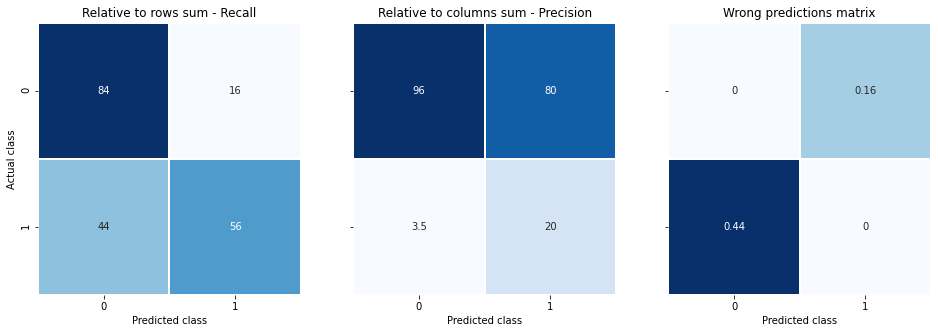

In [38]:
##### Batches structure
y_t_unique, y_t_counts = np.unique(y_train, return_counts=True)
y_v_unique, y_v_counts = np.unique(y_test, return_counts=True)

##### Predictions
predictions = model.predict(X_test)
predictions_2 = np.array([1 if (prediction > .5) else 0 for prediction in predictions ])

##### Confusion Matrix
cm = metrics.confusion_matrix(y_test, predictions_2)

##### Precision metrics
accuracy = (cm[0][0] + cm[1][1]) / cm.sum()
precision = cm[1][1] / (cm[1][1] + cm[0][1])
recall = cm[1][1] / (cm[1][1] + cm[1][0])
f1_score = 2 * ((precision * recall) / (precision + recall))

##### Visualization
print("Train structure:", dict(zip(y_t_unique, y_t_counts / len(y_train))))
print("Validation structure:", dict(zip(y_v_unique, y_v_counts / len(y_test))))
print()
print("#" * 50)
print("Confusion matrix:\n")
print(cm)
print("#" * 50)
print(">Accuracy:", accuracy)
print(">Precision:", precision)
print(">Recall:", recall)
print(">F1 Score:", f1_score)
print()
print()

# This is to calculate where the wrong predictions go in every column
row_sums = cm.sum(axis = 1, keepdims = True)    # rows sums
column_sums = cm.sum(axis = 0, keepdims = True)    # columns sums
norm_cm = cm / row_sums                         # Division by the column sum
np.fill_diagonal(norm_cm, 0)                    # Fill the diagonal with 0s

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 5), sharey = True)

sns.heatmap(cm / row_sums * 100, annot = True, linewidths = .1, cmap = "Blues", ax = ax1, cbar = False)
ax1.set_xlabel("Predicted class")
ax1.set_ylabel("Actual class")
ax1.set_title("Relative to rows sum - Recall")
sns.heatmap(cm / column_sums * 100, annot = True, linewidths = .1, cmap = "Blues", ax = ax2, cbar = False)
ax2.set_xlabel("Predicted class")
ax2.set_title("Relative to columns sum - Precision")
sns.heatmap(norm_cm, annot = True, linewidths = .1, cmap = "Blues", ax = ax3, cbar = False)
ax3.set_xlabel("Predicted class")
ax3.set_title("Wrong predictions matrix")

plt.show()

Text(0.5, 1.0, 'Accuracy')

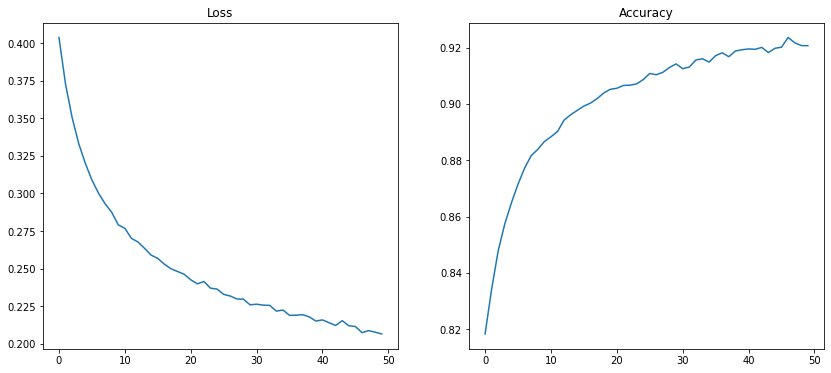

In [39]:
history.history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

ax1.plot(history.history["loss"])
ax1.set_title("Loss")
ax2.plot(history.history["accuracy"])
ax2.set_title("Accuracy")

## Machine learning models

In [40]:
# Model
#model = LogisticRegression(n_jobs = -1, random_state = 42, max_iter = 300)
model = RandomForestClassifier(n_jobs = -1, random_state = 42)
#model = KNeighborsClassifier(n_neighbors = 3, n_jobs = -1)

In [41]:
train_scores = []
val_scores = []
count = 1

for (train, val) in kfold.split(X_train, y_train):
    # Train-Validation sets
    x_t, y_t = X_train[train], y_train[train]
    x_v, y_v = X_train[val], y_train[val]


    # Internal structure
    y_t_unique, y_t_counts = np.unique(y_t, return_counts=True)
    y_v_unique, y_v_counts = np.unique(y_v, return_counts=True)

    # Training
    model.fit(x_t, y_t)

    # Scores
    train_score = model.score(x_t, y_t)
    val_score = model.score(x_v, y_v)

    train_scores.append(train_score)
    val_scores.append(val_score)

    print(f"\n-- Model {count} --")
    print("-" * 25)
    print("Set structure:")
    print("Train structure:", dict(zip(y_t_unique, y_t_counts / len(y_t))))
    print("Validation structure:", dict(zip(y_v_unique, y_v_counts / len(y_v))))
    print("-" * 25)
    print(">train score:", train_score)
    print(">test score:", val_score)
    print("#" * 75)

    count += 1


-- Model 1 --
-------------------------
Set structure:
Train structure: {0: 0.4999713614754568, 1: 0.5000286385245433}
Validation structure: {0: 0.500114547537228, 1: 0.49988545246277205}
-------------------------
>train score: 1.0
>test score: 0.9365406643757159
###########################################################################

-- Model 2 --
-------------------------
Set structure:
Train structure: {0: 0.4999713614754568, 1: 0.5000286385245433}
Validation structure: {0: 0.500114547537228, 1: 0.49988545246277205}
-------------------------
>train score: 1.0
>test score: 0.9422680412371134
###########################################################################

-- Model 3 --
-------------------------
Set structure:
Train structure: {0: 0.5000286385245433, 1: 0.4999713614754568}
Validation structure: {0: 0.49988545246277205, 1: 0.500114547537228}
-------------------------
>train score: 1.0
>test score: 0.9349369988545246
#####################################################

In [42]:
# Training with full train_data
model.fit(X_train, y_train)

# Internal structure
y_train_unique, y_train_counts = np.unique(y_train, return_counts=True)
y_test_unique, y_test_counts = np.unique(y_test, return_counts=True)

# Scores
train_score_ = model.score(X_train, y_train)
test_score_ = model.score(X_test, y_test)

# Prediction
prediction = model.predict(X_test)

# Features importance
try:
    importances = model.feature_importances_
    feature_importances = list(zip(features, importances))

    feature_importances_df = pd.DataFrame(feature_importances, columns = ["features", "importance"]).sort_values(by = "importance", ascending = False)

    print("\nFeature importances:")
    print(feature_importances_df)
    print()
    print("#" * 50)
except:
    pass

# Confusion matrix
cm = metrics.confusion_matrix(y_test, prediction)

print("\n-- Train set model --")
print("Train structure:", dict(zip(y_train_unique, y_train_counts / len(y_train) * 100)))
print(">Train score:", train_score_)
print()
print("-- Test set model --")
print("Validation structure:", dict(zip(y_test_unique, y_test_counts / len(y_test) * 100)))
print(">Test score:", test_score_)
print()
print("#" * 50)

print("\nConfusion matrix\n", cm)


Feature importances:
                                    features  importance
1   Age in years of the participant at the t    0.321257
13                  Waist Circumference (cm)    0.105959
11  Systolic:  Blood pressure (first reading    0.081393
12                               Weight (kg)    0.060765
14                 Total Cholesterol (mg/dL)    0.058427
10  Diastolic:  Blood pressure (first readin    0.050229
9                          Total sugars (gm)    0.040598
3                             Total fat (gm)    0.040590
2                           Cholesterol (mg)    0.039870
5                          Total sugars (gm)    0.038801
6                           Cholesterol (mg)    0.038323
4           Total saturated fatty acids (gm)    0.037564
8           Total saturated fatty acids (gm)    0.036845
7                             Total fat (gm)    0.036799
0                 Gender of the participant.    0.012582

##################################################

-- Train set 

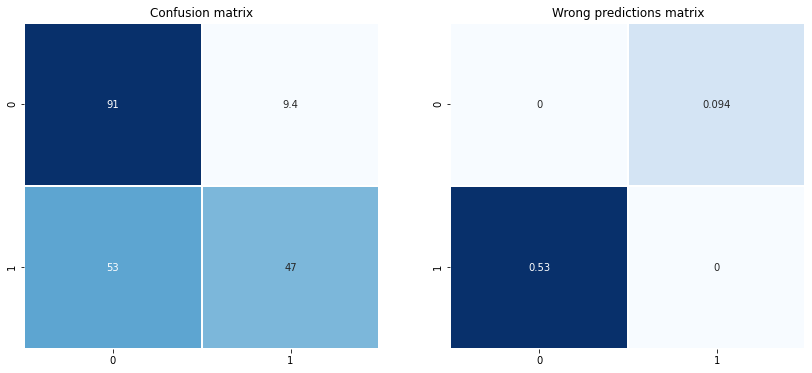

In [43]:
# This is to calculate where the wrong predictions go in every column
row_sums = cm.sum(axis = 1, keepdims = True)    # column sums
norm_cm = cm / row_sums                         # Division by the column sum
np.fill_diagonal(norm_cm, 0)                    # Fill the diagonal with 0s

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 6))

sns.heatmap(cm / row_sums * 100, annot = True, linewidths = .1, cmap = "Blues", ax = ax1, cbar = False)
ax1.set_title("Confusion matrix")
sns.heatmap(norm_cm, annot = True, linewidths = .1, cmap = "Blues", ax = ax2, cbar = False)
ax2.set_title("Wrong predictions matrix")

plt.show()

<AxesSubplot:>

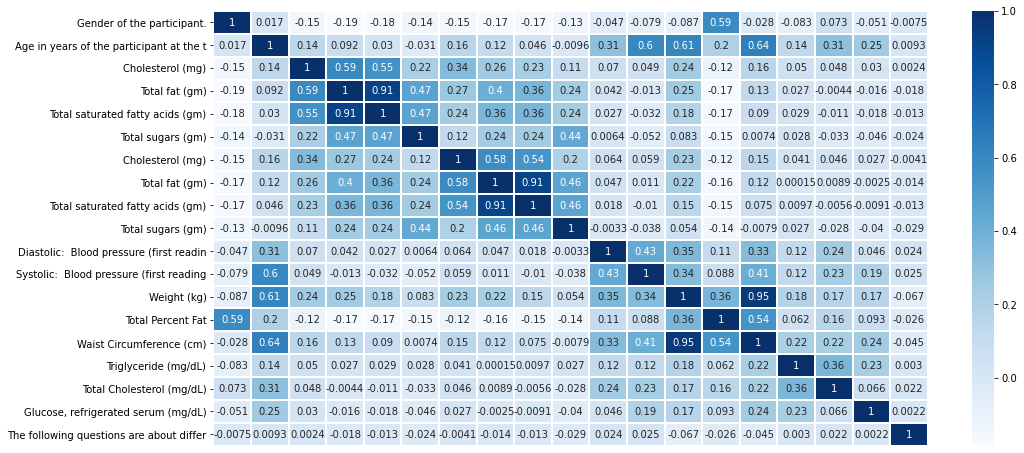

In [44]:
plt.figure(figsize = (16, 8))

to_plot = full_data.drop(["MCQ160B", "MCQ160C", "MCQ160D", "MCQ160E", "MCQ160F"], axis = 1)
labels = [md.var_descr_detector(column, variable_names)[:40] for column in to_plot.columns]

sns.heatmap(to_plot.corr(), annot = True, linewidths = .1, cmap = "Blues", yticklabels = labels, xticklabels = False)